In [34]:
import pandas as pd
import numpy as np
import os
import csv
from datetime import datetime 

#plot
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

#modle
import time
from sklearn.svm import OneClassSVM
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import matthews_corrcoef,cohen_kappa_score,balanced_accuracy_score

# Preprocessing 

In [2]:
#load the data
data=pd.read_csv("./dataset2/6903248_all.csv")
data

,datetime,platform_code,latitude,longitude,pressure,salinity,temperature,pres_qc,temp_qc,psal_qc,pres_anom,psal_anom,temp_anom
0,2018-09-26T12:01:30Z,6903248,43.84231,9.81552,47.2,38.088,16.762,1,1,1,0,0,0
1,2018-09-26T12:01:30Z,6903248,43.84231,9.81552,45.9,38.083,16.942,1,1,1,0,0,0
2,2018-09-26T12:01:30Z,6903248,43.84231,9.81552,45.0,38.053,17.051,1,1,1,0,0,0
3,2018-09-26T12:01:30Z,6903248,43.84231,9.81552,43.8,38.058,17.310,1,1,1,0,0,0
4,2018-09-26T12:01:30Z,6903248,43.84231,9.81552,42.8,38.063,17.617,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62791,2023-02-08T10:09:30Z,6903248,38.09164,8.71813,7.2,37.793,14.556,1,1,1,0,0,0
62792,2023-02-08T10:09:30Z,6903248,38.09164,8.71813,4.9,37.792,14.556,1,1,3,0,0,0
62793,2023-02-08T10:09:30Z,6903248,38.09164,8.71813,3.0,37.794,14.555,1,1,3,0,0,0
62794,2023-02-08T10:09:30Z,6903248,38.09164,8.71813,1.2,37.796,14.553,1,1,3,0,0,0


In [3]:
#generate label
mask = data[['pres_anom', 'psal_anom', 'temp_anom']].any(axis=1)
data['label']= mask.astype(int)
data

,datetime,platform_code,latitude,longitude,pressure,salinity,temperature,pres_qc,temp_qc,psal_qc,pres_anom,psal_anom,temp_anom,label
0,2018-09-26T12:01:30Z,6903248,43.84231,9.81552,47.2,38.088,16.762,1,1,1,0,0,0,0
1,2018-09-26T12:01:30Z,6903248,43.84231,9.81552,45.9,38.083,16.942,1,1,1,0,0,0,0
2,2018-09-26T12:01:30Z,6903248,43.84231,9.81552,45.0,38.053,17.051,1,1,1,0,0,0,0
3,2018-09-26T12:01:30Z,6903248,43.84231,9.81552,43.8,38.058,17.310,1,1,1,0,0,0,0
4,2018-09-26T12:01:30Z,6903248,43.84231,9.81552,42.8,38.063,17.617,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62791,2023-02-08T10:09:30Z,6903248,38.09164,8.71813,7.2,37.793,14.556,1,1,1,0,0,0,0
62792,2023-02-08T10:09:30Z,6903248,38.09164,8.71813,4.9,37.792,14.556,1,1,3,0,0,0,0
62793,2023-02-08T10:09:30Z,6903248,38.09164,8.71813,3.0,37.794,14.555,1,1,3,0,0,0,0
62794,2023-02-08T10:09:30Z,6903248,38.09164,8.71813,1.2,37.796,14.553,1,1,3,0,0,0,0


In [4]:
anomaly_data=data.loc[data['label'] == 1]
anomaly_data

,datetime,platform_code,latitude,longitude,pressure,salinity,temperature,pres_qc,temp_qc,psal_qc,pres_anom,psal_anom,temp_anom,label
492,2018-09-27T00:04:30Z,6903248,43.85908,9.81027,33.1,38.295,23.964,1,4,4,0,1,1,1
493,2018-09-27T00:04:30Z,6903248,43.85908,9.81027,31.9,38.427,23.954,1,4,4,0,1,1,1
1899,2018-09-28T09:10:30Z,6903248,43.90450,9.76723,32.8,38.278,23.489,1,4,4,0,1,1,1
1900,2018-09-28T09:10:30Z,6903248,43.90450,9.76723,32.0,38.372,23.603,1,4,4,0,1,1,1
1982,2018-09-28T12:03:30Z,6903248,43.91109,9.76117,62.9,38.043,15.212,1,4,4,0,1,1,1
1983,2018-09-28T12:03:30Z,6903248,43.91109,9.76117,62.0,38.072,15.175,1,4,4,0,1,1,1
5497,2018-10-01T18:02:30Z,6903248,44.06431,9.52557,33.8,38.051,19.211,1,4,4,0,1,1,1
5498,2018-10-01T18:02:30Z,6903248,44.06431,9.52557,32.9,38.510,19.211,1,4,4,0,1,1,1
12529,2018-10-08T12:08:30Z,6903248,44.32505,9.00599,73.2,38.117,15.369,1,4,4,0,1,1,1
12530,2018-10-08T12:08:30Z,6903248,44.32505,9.00599,72.3,38.168,15.383,1,4,4,0,1,1,1


In [5]:
anomaly_ratio=len(anomaly_data)/len(data)*100
anomaly_ratio

0.04299636919549016

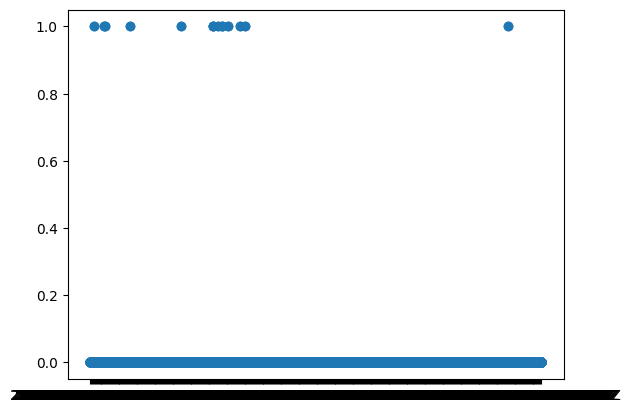

In [6]:
plt.scatter(data.datetime, data.label)
plt.show()

In [7]:
data.isna().sum()

datetime         0
platform_code    0
latitude         0
longitude        0
pressure         0
salinity         0
temperature      0
pres_qc          0
temp_qc          0
psal_qc          0
pres_anom        0
psal_anom        0
temp_anom        0
label            0
dtype: int64

In [8]:
data = data.dropna()
data.isna().sum()


datetime         0
platform_code    0
latitude         0
longitude        0
pressure         0
salinity         0
temperature      0
pres_qc          0
temp_qc          0
psal_qc          0
pres_anom        0
psal_anom        0
temp_anom        0
label            0
dtype: int64

In [9]:
#data.to_csv('3901890.csv', index=False)

# Z-score normalization 

In [10]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.drop(['platform_code', 'pres_qc','temp_qc','psal_qc','pres_anom','psal_anom','temp_anom'], axis=1)

data['datetime'] = pd.DatetimeIndex(data['datetime']).astype(int) // 10**9
data

,datetime,latitude,longitude,pressure,salinity,temperature,label
0,1537963290,43.84231,9.81552,47.2,38.088,16.762,0
1,1537963290,43.84231,9.81552,45.9,38.083,16.942,0
2,1537963290,43.84231,9.81552,45.0,38.053,17.051,0
3,1537963290,43.84231,9.81552,43.8,38.058,17.310,0
4,1537963290,43.84231,9.81552,42.8,38.063,17.617,0
...,...,...,...,...,...,...,...
62791,1675850970,38.09164,8.71813,7.2,37.793,14.556,0
62792,1675850970,38.09164,8.71813,4.9,37.792,14.556,0
62793,1675850970,38.09164,8.71813,3.0,37.794,14.555,0
62794,1675850970,38.09164,8.71813,1.2,37.796,14.553,0


In [11]:
row,col=data.shape
df=data.copy()
for i in range(0,col-1):
    mean = data.iloc[:,i].mean()
    std = np.std(data.iloc[:,i])
    df.iloc[:,i] = data.iloc[:,i].apply(lambda x: (x - mean) / std)
    
print(df)

       datetime  latitude  longitude  pressure  salinity  temperature  label
0     -1.030484  1.124407   1.340078 -0.591213 -0.336537     0.392348      0
1     -1.030484  1.124407   1.340078 -0.594255 -0.348713     0.450462      0
2     -1.030484  1.124407   1.340078 -0.596361 -0.421769     0.485653      0
3     -1.030484  1.124407   1.340078 -0.599170 -0.409593     0.569272      0
4     -1.030484  1.124407   1.340078 -0.601510 -0.397417     0.668388      0
...         ...       ...        ...       ...       ...          ...    ...
62791  1.964469 -0.878797   0.956935 -0.684821 -1.054926    -0.319867      0
62792  1.964469 -0.878797   0.956935 -0.690204 -1.057361    -0.319867      0
62793  1.964469 -0.878797   0.956935 -0.694650 -1.052490    -0.320190      0
62794  1.964469 -0.878797   0.956935 -0.698863 -1.047620    -0.320836      0
62795  1.964469 -0.878797   0.956935 -0.701437 -1.040314    -0.322450      0

[62796 rows x 7 columns]


# splite train test

In [12]:
#split the data and make sure the proportion in train and test set are equal
def getRandomSplit(data, size):
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.model_selection import train_test_split
    #train_set, test_set = train_test_split(data, test_size = size,random_state = 42)
    split = StratifiedShuffleSplit(n_splits = 1,test_size = size,random_state = 42)

    for train_index,test_index in split.split(data,data.iloc[:,-1]):
        train_set = data.iloc[train_index,:]
        test_set = data.iloc[test_index,:]

    print(len(train_set),len(test_set))
    return train_set,test_set
 

In [15]:
#split the last 10% data 

# window
def sliding_window(data, window_size):
    # from last raw
    for i in range(len(data)-1, window_size-2, -10):
        data_slice = data[i-window_size+1:i+1]
        ratio = (data_slice["label"] == 1).sum() / window_size*100
        print(ratio)
        if anomaly_ratio*0.85 <= ratio <= anomaly_ratio*1.15:
            #print(data_slice)
            return data_slice



def getLastSplit(data, size):
    data.sort_values("datetime", ascending=True, inplace=True)
    #print(data)
    row,col=data.shape
    window_size = int(size*row)
    test_set = sliding_window(data, window_size)
    time = test_set.iloc[0,0]
    #print(time)
    train_set = data[data['datetime'] < time]
    print(len(train_set),len(test_set))
    return train_set,test_set
# windows keep the same rate of anomaly

In [16]:
train_set1,test_set1 = getRandomSplit(df,0.1)
train_set2,test_set2 = getLastSplit(df,0.1)

56516 6280
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.03185220576524924
0.0318522

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.17518713170887085
0.19111323459149546
0.2070393374741201
0.2070393374741201
0.

In [17]:
# 285692 31744
# 264451 31743
train_set1 = train_set1.sample(n=len(train_set2))
#print(train_set1.shape)

In [18]:
instance = test_set1[(test_set1['label']==1)]
rate=len(instance)/len(test_set1)*100
print(rate)

0.04777070063694268


In [19]:
instance = test_set2[(test_set2['label']==1)]
rate=len(instance)/len(test_set2)*100
print(rate)

0.047778308647873864


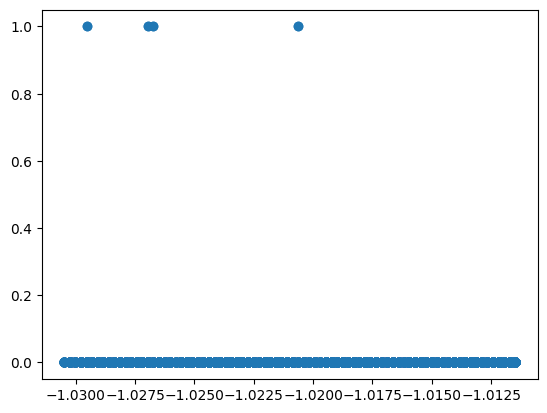

In [20]:
plt.scatter(train_set2.datetime, train_set2.label)
plt.show()

In [ ]:
plt.scatter(test_set2.datetime, test_set2.label)
plt.show()

# supervised

In [21]:
def write_file(metrics):
    filename = 'supervised_performance.csv'
    if os.path.isfile(filename):
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            for row in data:
                writer.writerow(metrics)
    else:
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            csv_writer.writerow(['pre', 'recall','f1'])
            for row in data:
                writer.writerow(metrics)


In [22]:
# metric
def computeMetric(y_tru,y_pre):
    acc = accuracy_score(y_tru,y_pre)
    pre = precision_score(y_tru,y_pre)
    recall=recall_score(y_tru,y_pre)
    cm=confusion_matrix(y_tru,y_pre)
    f1 = f1_score(y_tru,y_pre)
    mcc=matthews_corrcoef(y_tru, y_pre)
    kappa=cohen_kappa_score(y_tru, y_pre)
    bac=balanced_accuracy_score(y_tru,y_pre)
    print("acc:",acc)
    print("balanced acc:",bac)
    print("precision:",pre)
    print("recall:",recall)
    print("cm:",cm)
    print("f1:",f1)
    print("MCC:", mcc)
    print("Kappa:",kappa)
    metric=[pre,recall,f1]
    return metric
    
    
    # confusion matrix
    cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
    plt.subplots(figsize=(12,8))
    cf_matrix = confusion_matrix(y_tru, y_pre)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [23]:
def classSuper(train_set,test_set):
    x,y=data.shape
    score=[]
    models=[]
    # fit model and predict
    
    
    ##lightgbm
    print("lightgbm")
    clf1 = lgb.LGBMClassifier()
    clf1 = clf1.fit(train_set.iloc[:,0:y-1],train_set.iloc[:,y-1])
    y_pre1=clf1.predict(test_set.iloc[:,0:y-1])
    y_tru1=test_set.iloc[:,y-1]
    metric1=computeMetric(y_tru1,y_pre1)
    
    
    ## GradientBoosting
    print("GradientBoosting")
    from sklearn.ensemble import GradientBoostingClassifier
    clf2 = GradientBoostingClassifier()
    clf2.fit(train_set.iloc[:,0:y-1],train_set.iloc[:,y-1])
    y_pre2 = clf2.predict(test_set.iloc[:,0:y-1])
    metric2=computeMetric(y_tru1,y_pre2)
    
    ##catboost
    print("catboost")
    clf3 = CatBoostClassifier(loss_function='Logloss')
    clf3.fit(train_set.iloc[:,0:y-1],train_set.iloc[:,y-1])
    y_pre3 = clf3.predict(test_set.iloc[:,0:y-1])
    metric3=computeMetric(y_tru1,y_pre3)

    
    
    #KNN
    print("KNN")
    from sklearn.neighbors import KNeighborsClassifier
    clf4 = KNeighborsClassifier()
    dic4={'n_neighbors':[1,2,3,4,5,6,7,8,9]}
    #para11=getPar(clf11,dic11,p_set,10)
    clf4 = KNeighborsClassifier(n_jobs=-1)
    clf4.fit(train_set.iloc[:,0:y-1],train_set.iloc[:,y-1])

    y_pre4=clf4.predict(test_set.iloc[:,0:y-1])
    metric4=computeMetric(y_tru1,y_pre4)
    metrics = [metric1, metric2, metric3, metric4]
    return metrics
    

In [24]:
#random
metrics1=classSuper(train_set1,test_set1)

lightgbm
acc: 0.9960191082802548
balanced acc: 0.4982475704954596
precision: 0.0
recall: 0.0
cm: [[6255   22]
 [   3    0]]
f1: 0.0
MCC: -0.001296218226917549
Kappa: -0.000841471810694383
GradientBoosting


/Users/qiyiyang/opt/anaconda3/envs/al/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc: 0.9995222929936306
balanced acc: 0.5
precision: 0.0
recall: 0.0
cm: [[6277    0]
 [   3    0]]
f1: 0.0
MCC: 0.0
Kappa: 0.0
catboost
Learning rate set to 0.028331
0:	learn: 0.5972538	total: 62.4ms	remaining: 1m 2s
1:	learn: 0.5143568	total: 66.6ms	remaining: 33.2s
2:	learn: 0.4472209	total: 70.8ms	remaining: 23.5s
3:	learn: 0.3872008	total: 74.8ms	remaining: 18.6s
4:	learn: 0.3326884	total: 78.8ms	remaining: 15.7s
5:	learn: 0.2877939	total: 83ms	remaining: 13.7s
6:	learn: 0.2504098	total: 86.9ms	remaining: 12.3s
7:	learn: 0.2164831	total: 90.9ms	remaining: 11.3s
8:	learn: 0.1878597	total: 94.8ms	remaining: 10.4s
9:	learn: 0.1629296	total: 98.8ms	remaining: 9.78s
10:	learn: 0.1418935	total: 103ms	remaining: 9.23s
11:	learn: 0.1241176	total: 106ms	remaining: 8.76s
12:	learn: 0.1081926	total: 110ms	remaining: 8.37s
13:	learn: 0.0949416	total: 114ms	remaining: 8.04s
14:	learn: 0.0838158	total: 118ms	remaining: 7.76s
15:	learn: 0.0743272	total: 122ms	remaining: 7.52s
16:	learn: 0.065970

173:	learn: 0.0017049	total: 787ms	remaining: 3.73s
174:	learn: 0.0016903	total: 791ms	remaining: 3.73s
175:	learn: 0.0016820	total: 796ms	remaining: 3.73s
176:	learn: 0.0016746	total: 800ms	remaining: 3.72s
177:	learn: 0.0016669	total: 804ms	remaining: 3.71s
178:	learn: 0.0016574	total: 808ms	remaining: 3.71s
179:	learn: 0.0016499	total: 813ms	remaining: 3.7s
180:	learn: 0.0016389	total: 817ms	remaining: 3.7s
181:	learn: 0.0016277	total: 821ms	remaining: 3.69s
182:	learn: 0.0016186	total: 825ms	remaining: 3.68s
183:	learn: 0.0016104	total: 829ms	remaining: 3.68s
184:	learn: 0.0015982	total: 833ms	remaining: 3.67s
185:	learn: 0.0015890	total: 837ms	remaining: 3.66s
186:	learn: 0.0015831	total: 841ms	remaining: 3.65s
187:	learn: 0.0015756	total: 845ms	remaining: 3.65s
188:	learn: 0.0015615	total: 849ms	remaining: 3.64s
189:	learn: 0.0015579	total: 854ms	remaining: 3.64s
190:	learn: 0.0015486	total: 859ms	remaining: 3.64s
191:	learn: 0.0015400	total: 863ms	remaining: 3.63s
192:	learn: 0.

336:	learn: 0.0007725	total: 1.58s	remaining: 3.11s
337:	learn: 0.0007664	total: 1.58s	remaining: 3.1s
338:	learn: 0.0007632	total: 1.59s	remaining: 3.1s
339:	learn: 0.0007576	total: 1.59s	remaining: 3.09s
340:	learn: 0.0007556	total: 1.6s	remaining: 3.09s
341:	learn: 0.0007544	total: 1.6s	remaining: 3.08s
342:	learn: 0.0007492	total: 1.61s	remaining: 3.08s
343:	learn: 0.0007457	total: 1.61s	remaining: 3.07s
344:	learn: 0.0007422	total: 1.61s	remaining: 3.06s
345:	learn: 0.0007389	total: 1.62s	remaining: 3.06s
346:	learn: 0.0007372	total: 1.62s	remaining: 3.05s
347:	learn: 0.0007347	total: 1.63s	remaining: 3.05s
348:	learn: 0.0007333	total: 1.63s	remaining: 3.04s
349:	learn: 0.0007310	total: 1.63s	remaining: 3.04s
350:	learn: 0.0007289	total: 1.64s	remaining: 3.03s
351:	learn: 0.0007272	total: 1.64s	remaining: 3.02s
352:	learn: 0.0007259	total: 1.65s	remaining: 3.02s
353:	learn: 0.0007217	total: 1.65s	remaining: 3.01s
354:	learn: 0.0007207	total: 1.65s	remaining: 3.01s
355:	learn: 0.00

519:	learn: 0.0003925	total: 2.37s	remaining: 2.19s
520:	learn: 0.0003908	total: 2.37s	remaining: 2.18s
521:	learn: 0.0003897	total: 2.38s	remaining: 2.17s
522:	learn: 0.0003893	total: 2.38s	remaining: 2.17s
523:	learn: 0.0003880	total: 2.38s	remaining: 2.17s
524:	learn: 0.0003862	total: 2.39s	remaining: 2.16s
525:	learn: 0.0003858	total: 2.39s	remaining: 2.16s
526:	learn: 0.0003847	total: 2.4s	remaining: 2.15s
527:	learn: 0.0003830	total: 2.4s	remaining: 2.15s
528:	learn: 0.0003810	total: 2.41s	remaining: 2.14s
529:	learn: 0.0003797	total: 2.41s	remaining: 2.14s
530:	learn: 0.0003777	total: 2.41s	remaining: 2.13s
531:	learn: 0.0003767	total: 2.42s	remaining: 2.13s
532:	learn: 0.0003754	total: 2.42s	remaining: 2.12s
533:	learn: 0.0003750	total: 2.43s	remaining: 2.12s
534:	learn: 0.0003740	total: 2.43s	remaining: 2.11s
535:	learn: 0.0003727	total: 2.43s	remaining: 2.11s
536:	learn: 0.0003712	total: 2.44s	remaining: 2.1s
537:	learn: 0.0003693	total: 2.44s	remaining: 2.1s
538:	learn: 0.00

689:	learn: 0.0002535	total: 3.15s	remaining: 1.42s
690:	learn: 0.0002533	total: 3.16s	remaining: 1.41s
691:	learn: 0.0002529	total: 3.16s	remaining: 1.41s
692:	learn: 0.0002526	total: 3.17s	remaining: 1.4s
693:	learn: 0.0002524	total: 3.17s	remaining: 1.4s
694:	learn: 0.0002520	total: 3.17s	remaining: 1.39s
695:	learn: 0.0002517	total: 3.18s	remaining: 1.39s
696:	learn: 0.0002512	total: 3.18s	remaining: 1.38s
697:	learn: 0.0002503	total: 3.19s	remaining: 1.38s
698:	learn: 0.0002499	total: 3.19s	remaining: 1.37s
699:	learn: 0.0002495	total: 3.19s	remaining: 1.37s
700:	learn: 0.0002491	total: 3.2s	remaining: 1.36s
701:	learn: 0.0002487	total: 3.2s	remaining: 1.36s
702:	learn: 0.0002483	total: 3.21s	remaining: 1.35s
703:	learn: 0.0002479	total: 3.21s	remaining: 1.35s
704:	learn: 0.0002476	total: 3.21s	remaining: 1.34s
705:	learn: 0.0002470	total: 3.22s	remaining: 1.34s
706:	learn: 0.0002466	total: 3.22s	remaining: 1.34s
707:	learn: 0.0002457	total: 3.23s	remaining: 1.33s
708:	learn: 0.00

871:	learn: 0.0001747	total: 3.94s	remaining: 578ms
872:	learn: 0.0001744	total: 3.94s	remaining: 573ms
873:	learn: 0.0001741	total: 3.94s	remaining: 569ms
874:	learn: 0.0001740	total: 3.95s	remaining: 564ms
875:	learn: 0.0001735	total: 3.95s	remaining: 560ms
876:	learn: 0.0001733	total: 3.96s	remaining: 555ms
877:	learn: 0.0001731	total: 3.96s	remaining: 551ms
878:	learn: 0.0001726	total: 3.97s	remaining: 546ms
879:	learn: 0.0001724	total: 3.97s	remaining: 541ms
880:	learn: 0.0001723	total: 3.97s	remaining: 537ms
881:	learn: 0.0001720	total: 3.98s	remaining: 532ms
882:	learn: 0.0001717	total: 3.98s	remaining: 528ms
883:	learn: 0.0001713	total: 3.99s	remaining: 523ms
884:	learn: 0.0001711	total: 3.99s	remaining: 519ms
885:	learn: 0.0001707	total: 4s	remaining: 514ms
886:	learn: 0.0001704	total: 4s	remaining: 510ms
887:	learn: 0.0001700	total: 4.01s	remaining: 505ms
888:	learn: 0.0001695	total: 4.01s	remaining: 501ms
889:	learn: 0.0001693	total: 4.01s	remaining: 496ms
890:	learn: 0.0001

/Users/qiyiyang/opt/anaconda3/envs/al/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
metrics1
#write_file(metrics)

[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]

In [26]:
#last
# metrics2=classSuper(train_set2,test_set2)
# metrics2

In [27]:
train_set22,test_set22=getRandomSplit(train_set2, 0.175)
train_set22
#10373

8816 1871


,datetime,latitude,longitude,pressure,salinity,temperature,label
5739,-1.020163,1.204052,1.229153,-0.643634,0.296619,2.493481,0
2493,-1.025793,1.159823,1.306962,-0.650420,0.418380,2.637797,0
6582,-1.018522,1.209897,1.205855,-0.469288,0.021440,-0.449009,0
5436,-1.020631,1.201739,1.238845,-0.480287,-0.066228,-0.414463,0
1014,-1.028608,1.134474,1.336394,-0.682481,0.415945,2.672019,0
...,...,...,...,...,...,...,...
1339,-1.027901,1.138121,1.333514,-0.563131,-0.485085,-0.110658,0
1897,-1.026954,1.146071,1.323218,-0.619764,-0.519178,1.294402,0
2175,-1.026496,1.150947,1.317565,-0.681779,0.406204,2.685579,0
1278,-1.027901,1.138121,1.333514,-0.411485,0.145636,-0.430283,0


In [28]:
instance = test_set22[(test_set22['label']==1)]
rate=len(instance)/len(test_set22)*100
print(rate)

0.053447354355959376


In [29]:
metrics3=classSuper(train_set22,test_set2)

lightgbm
acc: 0.9982481286829112
balanced acc: 0.49936265137029956
precision: 0.0
recall: 0.0
cm: [[6268    8]
 [   3    0]]
f1: 0.0
MCC: -0.0007809005936963536
Kappa: -0.0006954405181032186
GradientBoosting
acc: 0.9990444338270426
balanced acc: 0.49976099426386233
precision: 0.0
recall: 0.0
cm: [[6273    3]
 [   3    0]]
f1: 0.0
MCC: -0.0004780114722753346
Kappa: -0.00047801147227533036
catboost
Learning rate set to 0.026095
0:	learn: 0.6088750	total: 3.6ms	remaining: 3.6s
1:	learn: 0.5323713	total: 6.68ms	remaining: 3.33s
2:	learn: 0.4640541	total: 9.5ms	remaining: 3.16s
3:	learn: 0.4067964	total: 12.3ms	remaining: 3.06s
4:	learn: 0.3554485	total: 15ms	remaining: 2.99s
5:	learn: 0.3111868	total: 17.7ms	remaining: 2.94s
6:	learn: 0.2715214	total: 20.5ms	remaining: 2.91s
7:	learn: 0.2385241	total: 23.4ms	remaining: 2.9s
8:	learn: 0.2108476	total: 26.2ms	remaining: 2.89s
9:	learn: 0.1859403	total: 29ms	remaining: 2.87s
10:	learn: 0.1636785	total: 31.7ms	remaining: 2.85s
11:	learn: 0.143

186:	learn: 0.0013790	total: 579ms	remaining: 2.52s
187:	learn: 0.0013727	total: 584ms	remaining: 2.52s
188:	learn: 0.0013622	total: 589ms	remaining: 2.53s
189:	learn: 0.0013544	total: 594ms	remaining: 2.53s
190:	learn: 0.0013426	total: 599ms	remaining: 2.54s
191:	learn: 0.0013344	total: 604ms	remaining: 2.54s
192:	learn: 0.0013252	total: 608ms	remaining: 2.54s
193:	learn: 0.0013117	total: 611ms	remaining: 2.54s
194:	learn: 0.0013010	total: 614ms	remaining: 2.54s
195:	learn: 0.0012977	total: 617ms	remaining: 2.53s
196:	learn: 0.0012867	total: 620ms	remaining: 2.53s
197:	learn: 0.0012684	total: 623ms	remaining: 2.52s
198:	learn: 0.0012638	total: 626ms	remaining: 2.52s
199:	learn: 0.0012495	total: 629ms	remaining: 2.52s
200:	learn: 0.0012380	total: 632ms	remaining: 2.51s
201:	learn: 0.0012282	total: 635ms	remaining: 2.51s
202:	learn: 0.0012172	total: 638ms	remaining: 2.5s
203:	learn: 0.0012144	total: 641ms	remaining: 2.5s
204:	learn: 0.0012075	total: 644ms	remaining: 2.5s
205:	learn: 0.0

387:	learn: 0.0004239	total: 1.17s	remaining: 1.84s
388:	learn: 0.0004229	total: 1.17s	remaining: 1.84s
389:	learn: 0.0004219	total: 1.17s	remaining: 1.83s
390:	learn: 0.0004212	total: 1.18s	remaining: 1.83s
391:	learn: 0.0004201	total: 1.18s	remaining: 1.83s
392:	learn: 0.0004182	total: 1.18s	remaining: 1.82s
393:	learn: 0.0004157	total: 1.19s	remaining: 1.82s
394:	learn: 0.0004139	total: 1.19s	remaining: 1.82s
395:	learn: 0.0004126	total: 1.19s	remaining: 1.82s
396:	learn: 0.0004117	total: 1.19s	remaining: 1.81s
397:	learn: 0.0004105	total: 1.2s	remaining: 1.81s
398:	learn: 0.0004085	total: 1.2s	remaining: 1.81s
399:	learn: 0.0004074	total: 1.2s	remaining: 1.8s
400:	learn: 0.0004055	total: 1.21s	remaining: 1.8s
401:	learn: 0.0004047	total: 1.21s	remaining: 1.8s
402:	learn: 0.0004042	total: 1.21s	remaining: 1.79s
403:	learn: 0.0004036	total: 1.21s	remaining: 1.79s
404:	learn: 0.0004027	total: 1.22s	remaining: 1.79s
405:	learn: 0.0004016	total: 1.22s	remaining: 1.79s
406:	learn: 0.0004

583:	learn: 0.0002493	total: 1.75s	remaining: 1.25s
584:	learn: 0.0002489	total: 1.75s	remaining: 1.25s
585:	learn: 0.0002483	total: 1.76s	remaining: 1.24s
586:	learn: 0.0002479	total: 1.76s	remaining: 1.24s
587:	learn: 0.0002472	total: 1.76s	remaining: 1.24s
588:	learn: 0.0002464	total: 1.77s	remaining: 1.23s
589:	learn: 0.0002457	total: 1.77s	remaining: 1.23s
590:	learn: 0.0002453	total: 1.77s	remaining: 1.23s
591:	learn: 0.0002445	total: 1.78s	remaining: 1.23s
592:	learn: 0.0002439	total: 1.78s	remaining: 1.22s
593:	learn: 0.0002438	total: 1.78s	remaining: 1.22s
594:	learn: 0.0002434	total: 1.79s	remaining: 1.22s
595:	learn: 0.0002432	total: 1.79s	remaining: 1.21s
596:	learn: 0.0002425	total: 1.79s	remaining: 1.21s
597:	learn: 0.0002421	total: 1.79s	remaining: 1.21s
598:	learn: 0.0002420	total: 1.8s	remaining: 1.2s
599:	learn: 0.0002416	total: 1.8s	remaining: 1.2s
600:	learn: 0.0002409	total: 1.8s	remaining: 1.2s
601:	learn: 0.0002405	total: 1.81s	remaining: 1.19s
602:	learn: 0.0002

768:	learn: 0.0001784	total: 2.34s	remaining: 703ms
769:	learn: 0.0001782	total: 2.35s	remaining: 701ms
770:	learn: 0.0001779	total: 2.35s	remaining: 698ms
771:	learn: 0.0001777	total: 2.35s	remaining: 695ms
772:	learn: 0.0001775	total: 2.35s	remaining: 692ms
773:	learn: 0.0001773	total: 2.36s	remaining: 689ms
774:	learn: 0.0001770	total: 2.36s	remaining: 686ms
775:	learn: 0.0001768	total: 2.37s	remaining: 683ms
776:	learn: 0.0001767	total: 2.37s	remaining: 680ms
777:	learn: 0.0001766	total: 2.37s	remaining: 677ms
778:	learn: 0.0001763	total: 2.38s	remaining: 674ms
779:	learn: 0.0001757	total: 2.38s	remaining: 671ms
780:	learn: 0.0001752	total: 2.38s	remaining: 668ms
781:	learn: 0.0001749	total: 2.38s	remaining: 665ms
782:	learn: 0.0001744	total: 2.39s	remaining: 662ms
783:	learn: 0.0001738	total: 2.39s	remaining: 659ms
784:	learn: 0.0001736	total: 2.39s	remaining: 656ms
785:	learn: 0.0001734	total: 2.4s	remaining: 653ms
786:	learn: 0.0001732	total: 2.4s	remaining: 650ms
787:	learn: 0.

955:	learn: 0.0001381	total: 2.93s	remaining: 135ms
956:	learn: 0.0001378	total: 2.93s	remaining: 132ms
957:	learn: 0.0001375	total: 2.94s	remaining: 129ms
958:	learn: 0.0001374	total: 2.94s	remaining: 126ms
959:	learn: 0.0001374	total: 2.94s	remaining: 123ms
960:	learn: 0.0001373	total: 2.94s	remaining: 120ms
961:	learn: 0.0001372	total: 2.95s	remaining: 117ms
962:	learn: 0.0001370	total: 2.95s	remaining: 113ms
963:	learn: 0.0001369	total: 2.96s	remaining: 110ms
964:	learn: 0.0001365	total: 2.96s	remaining: 107ms
965:	learn: 0.0001362	total: 2.96s	remaining: 104ms
966:	learn: 0.0001361	total: 2.96s	remaining: 101ms
967:	learn: 0.0001360	total: 2.97s	remaining: 98.2ms
968:	learn: 0.0001358	total: 2.97s	remaining: 95.1ms
969:	learn: 0.0001357	total: 2.98s	remaining: 92ms
970:	learn: 0.0001356	total: 2.98s	remaining: 89ms
971:	learn: 0.0001355	total: 2.98s	remaining: 85.9ms
972:	learn: 0.0001355	total: 2.98s	remaining: 82.8ms
973:	learn: 0.0001352	total: 2.99s	remaining: 79.9ms
974:	lear

/Users/qiyiyang/opt/anaconda3/envs/al/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc: 0.9995222169135213
balanced acc: 0.5
precision: 0.0
recall: 0.0
cm: [[6276    0]
 [   3    0]]
f1: 0.0
MCC: 0.0
Kappa: 0.0


/Users/qiyiyang/opt/anaconda3/envs/al/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
metrics3

[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]

In [31]:
metrics4=classSuper(train_set22,test_set22)

lightgbm
acc: 0.9978621058257616
balanced acc: 0.49919786096256685
precision: 0.0
recall: 0.0
cm: [[1867    3]
 [   1    0]]
f1: 0.0
MCC: -0.0009267260864040645
Kappa: -0.0008023535704735352
GradientBoosting
acc: 0.9983965793693212
balanced acc: 0.4994652406417112
precision: 0.0
recall: 0.0
cm: [[1868    2]
 [   1    0]]
f1: 0.0
MCC: -0.0007564662278430297
Kappa: -0.0007131395970760845
catboost
Learning rate set to 0.026095
0:	learn: 0.6088750	total: 3.48ms	remaining: 3.48s
1:	learn: 0.5323713	total: 6.64ms	remaining: 3.31s
2:	learn: 0.4640541	total: 10.4ms	remaining: 3.46s
3:	learn: 0.4067964	total: 13.5ms	remaining: 3.36s
4:	learn: 0.3554485	total: 16.4ms	remaining: 3.27s
5:	learn: 0.3111868	total: 19.5ms	remaining: 3.23s
6:	learn: 0.2715214	total: 22.6ms	remaining: 3.2s
7:	learn: 0.2385241	total: 26ms	remaining: 3.22s
8:	learn: 0.2108476	total: 29.2ms	remaining: 3.22s
9:	learn: 0.1859403	total: 32.9ms	remaining: 3.26s
10:	learn: 0.1636785	total: 36ms	remaining: 3.24s
11:	learn: 0.14

175:	learn: 0.0014934	total: 565ms	remaining: 2.65s
176:	learn: 0.0014806	total: 568ms	remaining: 2.64s
177:	learn: 0.0014742	total: 571ms	remaining: 2.64s
178:	learn: 0.0014585	total: 574ms	remaining: 2.63s
179:	learn: 0.0014469	total: 577ms	remaining: 2.63s
180:	learn: 0.0014402	total: 580ms	remaining: 2.62s
181:	learn: 0.0014288	total: 583ms	remaining: 2.62s
182:	learn: 0.0014139	total: 587ms	remaining: 2.62s
183:	learn: 0.0014023	total: 590ms	remaining: 2.62s
184:	learn: 0.0013933	total: 593ms	remaining: 2.61s
185:	learn: 0.0013859	total: 596ms	remaining: 2.61s
186:	learn: 0.0013790	total: 599ms	remaining: 2.6s
187:	learn: 0.0013727	total: 602ms	remaining: 2.6s
188:	learn: 0.0013622	total: 605ms	remaining: 2.6s
189:	learn: 0.0013544	total: 608ms	remaining: 2.59s
190:	learn: 0.0013426	total: 611ms	remaining: 2.59s
191:	learn: 0.0013344	total: 614ms	remaining: 2.58s
192:	learn: 0.0013252	total: 617ms	remaining: 2.58s
193:	learn: 0.0013117	total: 620ms	remaining: 2.58s
194:	learn: 0.0

361:	learn: 0.0004721	total: 1.15s	remaining: 2.03s
362:	learn: 0.0004710	total: 1.15s	remaining: 2.02s
363:	learn: 0.0004684	total: 1.16s	remaining: 2.02s
364:	learn: 0.0004659	total: 1.16s	remaining: 2.02s
365:	learn: 0.0004648	total: 1.16s	remaining: 2.01s
366:	learn: 0.0004635	total: 1.17s	remaining: 2.01s
367:	learn: 0.0004622	total: 1.17s	remaining: 2.01s
368:	learn: 0.0004610	total: 1.17s	remaining: 2s
369:	learn: 0.0004594	total: 1.17s	remaining: 2s
370:	learn: 0.0004566	total: 1.18s	remaining: 2s
371:	learn: 0.0004541	total: 1.18s	remaining: 1.99s
372:	learn: 0.0004529	total: 1.18s	remaining: 1.99s
373:	learn: 0.0004508	total: 1.19s	remaining: 1.99s
374:	learn: 0.0004498	total: 1.19s	remaining: 1.98s
375:	learn: 0.0004471	total: 1.19s	remaining: 1.98s
376:	learn: 0.0004461	total: 1.2s	remaining: 1.98s
377:	learn: 0.0004433	total: 1.2s	remaining: 1.97s
378:	learn: 0.0004412	total: 1.2s	remaining: 1.97s
379:	learn: 0.0004393	total: 1.21s	remaining: 1.97s
380:	learn: 0.0004371	to

556:	learn: 0.0002634	total: 1.73s	remaining: 1.38s
557:	learn: 0.0002627	total: 1.74s	remaining: 1.37s
558:	learn: 0.0002622	total: 1.74s	remaining: 1.37s
559:	learn: 0.0002617	total: 1.74s	remaining: 1.37s
560:	learn: 0.0002612	total: 1.75s	remaining: 1.36s
561:	learn: 0.0002605	total: 1.75s	remaining: 1.36s
562:	learn: 0.0002600	total: 1.75s	remaining: 1.36s
563:	learn: 0.0002595	total: 1.75s	remaining: 1.36s
564:	learn: 0.0002590	total: 1.76s	remaining: 1.35s
565:	learn: 0.0002585	total: 1.76s	remaining: 1.35s
566:	learn: 0.0002578	total: 1.76s	remaining: 1.35s
567:	learn: 0.0002573	total: 1.77s	remaining: 1.34s
568:	learn: 0.0002568	total: 1.77s	remaining: 1.34s
569:	learn: 0.0002564	total: 1.77s	remaining: 1.34s
570:	learn: 0.0002557	total: 1.78s	remaining: 1.33s
571:	learn: 0.0002550	total: 1.78s	remaining: 1.33s
572:	learn: 0.0002544	total: 1.78s	remaining: 1.33s
573:	learn: 0.0002540	total: 1.78s	remaining: 1.32s
574:	learn: 0.0002539	total: 1.79s	remaining: 1.32s
575:	learn: 

742:	learn: 0.0001864	total: 2.32s	remaining: 803ms
743:	learn: 0.0001861	total: 2.33s	remaining: 800ms
744:	learn: 0.0001860	total: 2.33s	remaining: 797ms
745:	learn: 0.0001858	total: 2.33s	remaining: 794ms
746:	learn: 0.0001857	total: 2.33s	remaining: 790ms
747:	learn: 0.0001851	total: 2.34s	remaining: 787ms
748:	learn: 0.0001844	total: 2.34s	remaining: 784ms
749:	learn: 0.0001842	total: 2.34s	remaining: 781ms
750:	learn: 0.0001835	total: 2.35s	remaining: 778ms
751:	learn: 0.0001832	total: 2.35s	remaining: 775ms
752:	learn: 0.0001830	total: 2.35s	remaining: 772ms
753:	learn: 0.0001828	total: 2.36s	remaining: 769ms
754:	learn: 0.0001825	total: 2.36s	remaining: 766ms
755:	learn: 0.0001823	total: 2.36s	remaining: 762ms
756:	learn: 0.0001820	total: 2.37s	remaining: 759ms
757:	learn: 0.0001813	total: 2.37s	remaining: 756ms
758:	learn: 0.0001811	total: 2.37s	remaining: 753ms
759:	learn: 0.0001808	total: 2.37s	remaining: 750ms
760:	learn: 0.0001806	total: 2.38s	remaining: 747ms
761:	learn: 

921:	learn: 0.0001437	total: 2.91s	remaining: 246ms
922:	learn: 0.0001436	total: 2.91s	remaining: 243ms
923:	learn: 0.0001434	total: 2.91s	remaining: 240ms
924:	learn: 0.0001433	total: 2.92s	remaining: 236ms
925:	learn: 0.0001431	total: 2.92s	remaining: 233ms
926:	learn: 0.0001430	total: 2.92s	remaining: 230ms
927:	learn: 0.0001429	total: 2.93s	remaining: 227ms
928:	learn: 0.0001426	total: 2.93s	remaining: 224ms
929:	learn: 0.0001424	total: 2.93s	remaining: 221ms
930:	learn: 0.0001423	total: 2.94s	remaining: 218ms
931:	learn: 0.0001420	total: 2.94s	remaining: 214ms
932:	learn: 0.0001419	total: 2.94s	remaining: 211ms
933:	learn: 0.0001417	total: 2.94s	remaining: 208ms
934:	learn: 0.0001415	total: 2.95s	remaining: 205ms
935:	learn: 0.0001412	total: 2.95s	remaining: 202ms
936:	learn: 0.0001411	total: 2.95s	remaining: 199ms
937:	learn: 0.0001409	total: 2.96s	remaining: 195ms
938:	learn: 0.0001407	total: 2.96s	remaining: 192ms
939:	learn: 0.0001407	total: 2.96s	remaining: 189ms
940:	learn: 

/Users/qiyiyang/opt/anaconda3/envs/al/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/qiyiyang/opt/anaconda3/envs/al/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
metrics4

[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]

# unsupervised

In [40]:
train_set1.iloc[:,:6]

,datetime,latitude,longitude,pressure,salinity,temperature
6375,-1.018991,1.207682,1.213693,-0.633571,-0.477779,1.081964
44825,0.724155,-0.727178,-0.056324,-0.687630,-2.182431,0.030752
39188,0.339435,-1.072072,-0.562618,0.247283,0.949257,-0.621412
46983,0.874307,-0.923991,-0.416570,-0.590511,-2.026577,-0.010573
12384,-1.008195,1.290849,1.066010,-0.441908,-0.073533,-0.378626
...,...,...,...,...,...,...
22933,-0.861597,0.924779,0.309414,-0.675929,-0.409593,0.221559
33,-1.030484,1.124407,1.340078,-0.671248,0.493872,2.754024
18016,-0.998349,1.166463,0.775610,-0.486606,-0.217211,-0.148432
49710,1.061954,-0.755999,0.429602,-0.613913,-3.857860,0.914403


In [63]:
# fit the model
clf = OneClassSVM(nu=0.1, kernel='linear', gamma='scale')
clf.fit(train_set1.iloc[:,:6])
y_pred_train = clf.predict(train_set1.iloc[:,:6])
y_pred_test = clf.predict(test_set1.iloc[:,:6])
y_pred_test = np.where(y_pred_test == 1, 0, np.where(y_pred_test == -1, 1, y_pred_test))          
y_pred_test


array([0, 1, 1, ..., 1, 1, 1])

In [64]:
metrics5 = computeMetric(test_set1.iloc[:,6],y_pred_test)

acc: 0.24060509554140128
balanced acc: 0.45353406616748976
precision: 0.0004192872117400419
recall: 0.6666666666666666
cm: [[1509 4768]
 [   1    2]]
f1: 0.0008380473496752567
MCC: -0.004751751208429042
Kappa: -0.00011687774787927374


In [65]:
metrics5

[0.0004192872117400419, 0.6666666666666666, 0.0008380473496752567]

In [ ]:
# plot the line , the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
 
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
 
s =40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s, edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s, edgecolors='k')
 
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", 'training observations',
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200; errors novel regular: %d/40; errors novel abnormal:%d/40"%(
        n_error_train, n_error_test, n_error_outlier)    )
plt.show()